In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from collections import Counter
# svg output in plots
import numpy as np
import tqdm as tqdm
from itertools import chain
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Parameters

In [7]:
# Load data
df = pd.read_pickle(r"../Dataset/dataframe.pkl")
df = df[df["Time"] > 1950]

df_i = df.explode("Simplices").reset_index()
all_authors = df_i["Simplices"].unique()
N_a = len(all_authors)
print("Number of authors:", N_a)

Number of authors: 1242372


In [8]:
### Initial condition age distribution

df_all = pd.read_pickle(r"../Dataset/dataframe.pkl")
df_all = df_all.explode("Simplices").reset_index()
all_ini = df_all.groupby("Simplices").min("Time").reset_index()

all_ini["Age"] = 1950 -  all_ini["Time"]

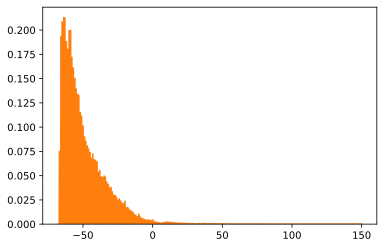

In [9]:
x = plt.hist(all_ini["Age"], bins=1000, density=True, cumulative=False);

plt.plot(x[1][1:], x[0], label="Initial condition")

### Academic age distribution

x_life = x[1][1:] + 40     #np.linspace(0,80,1001)
f_life = x[0]
#plt.plot(x_life,f_life,color="black",linestyle="",marker=".",linewidth=4)

all_ages = np.random.choice(x_life, size=len(all_authors), p=f_life/np.sum(f_life))

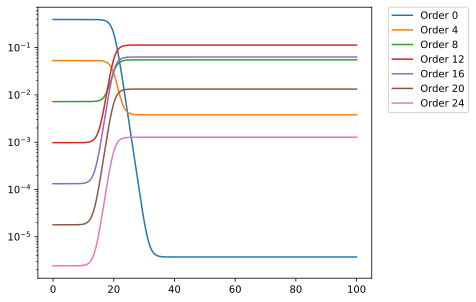

In [10]:
def dist_order(order,age,N):
    alpha = 0.5*(1 + np.tanh(0.5*(age-20)))
    s = 0.5
    Z = np.sum([np.exp(-0.5*o) for o in range(N)])
    e = np.exp(-0.5*order)/Z
    lam = N/2
    Pois = np.exp(-lam)*lam**(order)/np.math.factorial(order)
    return (1-alpha)*e + alpha*Pois

fig, ax = plt.subplots(figsize=(6,5))
v = np.linspace(0,100, 1001)
for order in range(0, 25, 4):
    plt.plot(v, dist_order(order, v, 25), label="Order {}".format(order))
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout
plt.yscale("log")

In [12]:
t0 = 1950
tf = 2010

# Not all authors at the reservoir
N_a = 1000
authors = np.array(all_authors[0:N_a])
ages = np.array(all_ages[0:N_a])

# Parameters
N = 25 # Maximum number of orders
r = (np.log(10**5 - 10**3))/60 # simplices x year
N_simplices = 10 # Number of simplices at t0

# If the ages are < 0 or > age_max, we set M = 0
age_max = 80

ti = t0

simplices = []
time = []

def p(x, age_max=age_max):
    if x > age_max:
        return 0
    elif x <= 0:
        return 0
    else:
        return 1/(1+x)

def dist_order(order,age,N):
    alpha = 0.5*(1 + np.tanh(0.5*(age-20)))
    s = 0.4
    Z = np.sum([np.exp(-s*o) for o in range(N)])
    e = np.exp(-s*order)/Z
    lam = (N)/3
    Pois = np.exp(-lam)*lam**(order)/np.math.factorial(order)
    return (1-alpha)*e + alpha*Pois

w_t = 0
print("Model starts running")
while ti < tf:
    # Compute total rate:
    W = (r+1)*N_simplices
    
    # Compute next event time
    At = - np.log(np.random.rand())/W
    
    # Time goes on
    ti = ti + At
    w_t = w_t + At
    ages = ages + At

    # Choose main author according to the age
    possible_authors = np.where(ages > 0)[0]
    i_a = np.random.randint(0,len(possible_authors))
    i_a = possible_authors[i_a]
    while np.random.rand() > p(ages[i_a]):
        i_a = np.random.randint(0,N_a)
    
    # i_a is the main author
    age = ages[i_a]
    o_i = np.random.choice(range(N),p=[dist_order(order,age,N) for order in range(N)]/np.sum([dist_order(order,age,N) for order in range(N)]))
    if o_i > 0:
        possible_collaborators_index = np.where(ages > 0)[0]
        i_c = np.random.choice(possible_collaborators_index,size=o_i,replace=False)
        collaborators = [authors[i] for i in i_c]
        # We update the memory matrix with the new collaboration
    if o_i > 5:
        simplices.append([authors[i_a]] + collaborators)
        time.append(ti)
    if w_t > 1:
        N_simplices = len(simplices)
        print(ti,N_simplices)
        w_t = 0

Model starts running
1951.0572653351744 3
1952.2620848176211 3
1953.2631224209822 4
1954.4839254560782 4
1955.4898196263534 4
1956.5763040274749 5
1957.8155882872427 7
1959.0494682690135 9
1960.1891987551126 13
1961.264279572785 15
1962.270165163725 17
1963.3621294510092 21
1964.3741312375707 23
1965.3818253238844 30
1966.4008102108273 36
1967.422204935695 41
1968.436036014331 46
1969.459768598563 51
1970.4667140098243 61
1971.5333919033326 73
1972.5632378173616 84
1973.5637298057254 103
1974.564954113868 118
1975.5732067923734 137
1976.580315050755 156
1977.582543339134 182
1978.5852217482543 217
1979.5918905170472 257
1980.5957925443738 314
1981.5985816895995 404
1982.5985821758359 532
1983.5995490165267 722
1984.6043939885728 972
1985.6057982480381 1379
1986.6076569553675 2005
1987.6085422355034 2981
1988.609369198754 4575
1989.6093945549342 7189
1990.6094881685558 11886
1991.6095151244776 19916
1992.6095627480518 34726
1993.6095631884896 62511
1994.6095668187522 115446
1995.6095747

KeyboardInterrupt: 

In [13]:
df = pd.DataFrame({"Time":time,"Simplices":simplices})

In [15]:
df.to_pickle("./Outcomes/Random_model.pkl")